In [1]:
import matplotlib.pyplot as plt

from neurostates.core.classification import Frequencies
from neurostates.core.clustering import Concatenator
from neurostates.core.connectivity import DynamicConnectivity, DynamicConnectivityGroup
from neurostates.core.window import SecondsWindower, SecondsWindowerGroup, SamplesWindowerGroup


import numpy as np

import scipy.io as sio

from sklearn.cluster import KMeans
from sklearn.pipeline import Pipeline

In [2]:
group_controls = sio.loadmat(
    "tests/core/dataset/controls_singleprec.mat"
)["ts"]
group_patients = sio.loadmat(
    "tests/core/dataset/patients_singleprec.mat"
)["ts"]

n_rois = group_controls.shape[1]

groups = {
    "controls": group_controls,
    "patients": group_patients
}

group_controls.shape, group_patients.shape

((10, 90, 500), (10, 90, 500))

In [3]:
brain_state_pipeline = Pipeline(
    [
        ("windower", SecondsWindowerGroup(length=20, step=5, sample_rate=1)),
        #("windower", SamplesWindowerGroup(length=20, step=5)),
        ("connectivity", DynamicConnectivityGroup(method=np.corrcoef)),
        ("preclustering", Concatenator()),
        ("clustering", KMeans(n_clusters=3, random_state=42)),
    ]
)

brain_states = brain_state_pipeline.fit_transform(groups)
centroids = brain_state_pipeline["clustering"].cluster_centers_
centroids.shape

(3, 8100)

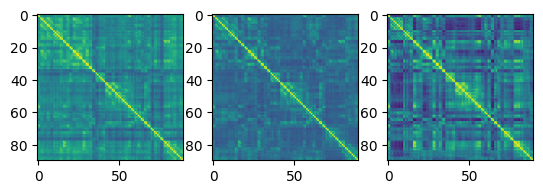

In [11]:
fig, ax = plt.subplots(1, 3)
ax[0].imshow(centroids[0, :].reshape(n_rois, n_rois), vmin=-0.5, vmax=1)
ax[1].imshow(centroids[1, :].reshape(n_rois, n_rois), vmin=-0.5, vmax=1)
ax[2].imshow(centroids[2, :].reshape(n_rois, n_rois), vmin=-0.5, vmax=1)

In [5]:
frequencies = Frequencies(centroids=centroids)
freqs = frequencies.transform(brain_state_pipeline["connectivity"].dict_of_groups_)

freqs.keys(), freqs["controls"].shape

(dict_keys(['controls', 'patients']), (10, 3))

<BarContainer object of 2 artists>

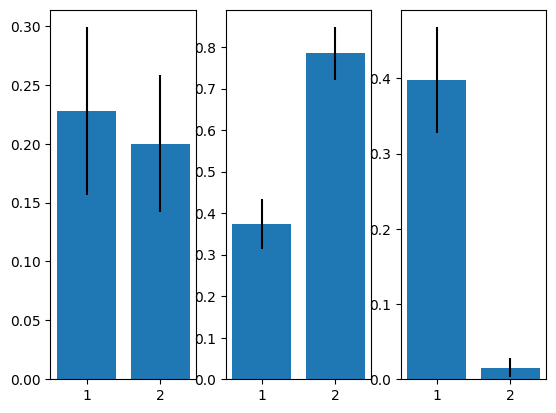

In [6]:
mean_controls = np.mean(freqs["controls"], axis=0)
mean_patients = np.mean(freqs["patients"], axis=0)
std_controls = np.std(freqs["controls"], axis=0) / np.sqrt(len(group_patients))
std_patients = np.std(freqs["patients"], axis=0) / np.sqrt(len(group_controls))

fig, ax = plt.subplots(1, 3)
ax[0].bar([1, 2], [mean_controls[0], mean_patients[0]], yerr=[std_controls[0], std_patients[0]])
ax[1].bar([1, 2], [mean_controls[1], mean_patients[1]], yerr=[std_controls[1], std_patients[1]])
ax[2].bar([1, 2], [mean_controls[2], mean_patients[2]], yerr=[std_controls[2], std_patients[2]])